Độ chính xác của K-means trên dữ liệu Iris: 0.89


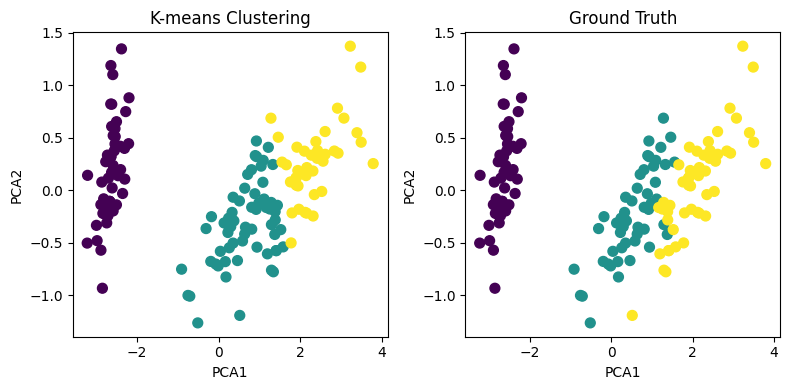

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Đọc dữ liệu
df = pd.read_csv('iris.csv')

# 2. Tách đặc trưng và nhãn
X = df.drop(columns=['species'])        # Dữ liệu đầu vào
y_true = df['species']                  # Nhãn thật

# 3. Mã hóa nhãn thành số (ví dụ: setosa -> 0, versicolor -> 1,...)
encoder = LabelEncoder()
y_true_encoded = encoder.fit_transform(y_true)

# 4. Huấn luyện K-means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

# 5. Dự đoán nhãn cụm
y_pred = kmeans.labels_

# 6. Vì K-means không có khái niệm "nhãn đúng", ta cần ánh xạ lại nhãn cho đúng
# Xây confusion matrix để xem cần ánh xạ thế nào
conf_mat = confusion_matrix(y_true_encoded, y_pred)

# Tự động ánh xạ nhãn K-means về đúng nhãn gốc (theo đa số)
from scipy.stats import mode

def map_labels(y_true, y_pred):
    labels = np.zeros_like(y_pred)
    for i in range(3):  # vì có 3 cụm
        mask = (y_pred == i)
        labels[mask] = mode(y_true[mask], keepdims=False).mode
    return labels

y_pred_mapped = map_labels(y_true_encoded, y_pred)

# 7. Tính độ chính xác
acc = accuracy_score(y_true_encoded, y_pred_mapped)
print(f'Độ chính xác của K-means trên dữ liệu Iris: {acc:.2f}')

# 8. Trực quan hóa kết quả phân cụm (giảm chiều bằng PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("K-means Clustering")
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_mapped, cmap='viridis', s=50)
plt.xlabel('PCA1'); plt.ylabel('PCA2')

plt.subplot(1, 2, 2)
plt.title("Ground Truth")
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_true_encoded, cmap='viridis', s=50)
plt.xlabel('PCA1'); plt.ylabel('PCA2')

plt.tight_layout()
plt.show()


Độ chính xác của K-means tự viết: 0.89


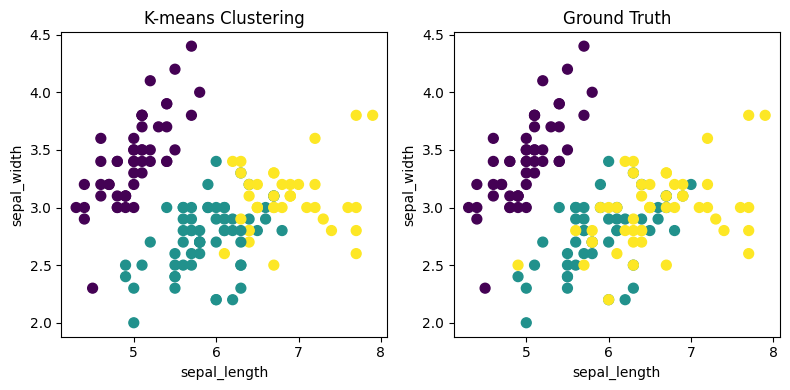

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# 1. Đọc dữ liệu
df = pd.read_csv('iris.csv')

# 2. Tách đặc trưng và nhãn
X = df.drop(columns=['species']).values  # (150, 4)
y_true = df['species'].values

# 3. Mã hóa nhãn thành số
label_map = {label: idx for idx, label in enumerate(np.unique(y_true))}
y_true_encoded = np.array([label_map[label] for label in y_true])

# 4. K-means thủ công
def euclidean(a, b):
    return np.linalg.norm(a - b)

def initialize_centroids(X, k):
    np.random.seed(0)
    idx = np.random.choice(len(X), k, replace=False)
    return X[idx]

def assign_clusters(X, centroids):
    clusters = []
    for x in X:
        distances = [euclidean(x, c) for c in centroids]
        cluster = np.argmin(distances)
        clusters.append(cluster)
    return np.array(clusters)

def update_centroids(X, clusters, k):
    new_centroids = []
    for i in range(k):
        points = X[clusters == i]
        if len(points) == 0:
            new_centroids.append(np.zeros(X.shape[1]))  # tránh lỗi chia cho 0
        else:
            new_centroids.append(points.mean(axis=0))
    return np.array(new_centroids)

def kmeans(X, k=3, max_iter=100, tol=1e-4):
    centroids = initialize_centroids(X, k)
    for _ in range(max_iter):
        clusters = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, clusters, k)
        if np.allclose(centroids, new_centroids, atol=tol):
            break
        centroids = new_centroids
    return clusters, centroids

# 5. Chạy K-means
k = 3
y_pred, centroids = kmeans(X, k)

# 6. Ánh xạ nhãn cụm về đúng nhãn thật (theo đa số)
def map_cluster_labels(y_pred, y_true_encoded, k=3):
    label_mapping = {}
    for i in range(k):
        true_labels = y_true_encoded[y_pred == i]
        if len(true_labels) == 0:
            label_mapping[i] = -1
        else:
            label_mapping[i] = Counter(true_labels).most_common(1)[0][0]
    y_pred_mapped = np.array([label_mapping[cluster] for cluster in y_pred])
    return y_pred_mapped

y_pred_mapped = map_cluster_labels(y_pred, y_true_encoded)

# 7. Tính độ chính xác
accuracy = np.mean(y_pred_mapped == y_true_encoded)
print(f'Độ chính xác của K-means tự viết: {accuracy:.2f}')

# 8. Trực quan hóa với matplotlib (dùng 2 đặc trưng đầu)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("K-means Clustering")
plt.scatter(X[:, 0], X[:, 1], c=y_pred_mapped, cmap='viridis', s=50)
plt.xlabel('sepal_length'); plt.ylabel('sepal_width')

plt.subplot(1, 2, 2)
plt.title("Ground Truth")
plt.scatter(X[:, 0], X[:, 1], c=y_true_encoded, cmap='viridis', s=50)
plt.xlabel('sepal_length'); plt.ylabel('sepal_width')

plt.tight_layout()
plt.show()
